# Plan

1. **Load Sequences from file**
    1. Load all sequences for example from all Interpro seqs
    2. Get Subset of YcaO domain if working on that
    
2. **Filter sequences**
    1. Filter by size, **# 300<len<700**
    2. **Filter out using CD-HIT**
    
2. **Derive MSA**    
    1. **Opt1** using Mafft, use high quality MSA
    2. **Opt2** using HMMalign, use preexisting MSA hmm file
    
3. **Filter out additional sequences**
    1. Use Cluster.py to cluster sequences
    2. Remove Clusters with less than 10 elements
    3. **--Optional--** Remove additional sequences with CD-HIT

## New Pathway
1. **Load MSA file from UniPro**

### ---Data Validation---

2. Check if Accession IDs are those in the interpro set of sequences
    - Only use subset of proteins that are from the interpro set because I have additional data on those
2. B Identify Sequences you'd want to be in there but aren't (namely the bottromycin ones
3. Get lengths of sequences and  ensure they are correct sizes **# 300<len<700**
3. B - Remove sequences that contain Undetermined codons
4. Cluster Sequences
    1. Cluster sequences with Cluster.py
    2. Remove Clusters with less than 10 elements
5. Remove highly similar sequences with CD-HIT
6. Check MSA, remove columns with no coverage


## Create Tree Using  iq-Tree2

## ---Tree Creation---
1. Identify sequences with E1 domains nearby
2. Identify sequences with TfuA nearby
3. Identify sequences with an E1 in them #tridomain YcaOs
4. Mark sequences with whether they are bacterial archaeal or a more detailed ancestry
5. Identify other RiPP essential machinery using RODEO
6. **Identify essential positions in the tree, worthy of ancestral sequence reconstruction**

## Ancestral Sequence Validation
1. Calculate mean Probability of sequence (hopefully over 80%)
2. Identify really similar probabilities to be able to come up with similar likelihood sequences
3. Align Sequence with TruD and PatD and EcYcaO
4. Make Alfafold predict structure


## Plasmid Design?

In [ ]:
import os
import glob
from Bio import SeqIO
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np
import copy

# Load Sequences
These are the results for searching a database for homologues of:
- thioamide
- macroamidine
- azoline

#### Alternatively, Load the Interpro database sequences 

In [ ]:
seqdump_dirs = glob.glob("../**/**seqdump.fa",recursive = True)

unique_sequence_ids = []
unique_sequences = []
num_sequences = 0
seqrecs_list = []
selected_seqdump_dirs = []
for seqdump_dir in seqdump_dirs:
    seqrecs = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")]
    print(f"{seqdump_dir} has {len(seqrecs)} sequences")
    seqrecs_list.append(seqrecs)
    #Me removing certain files
    if ("Lasso" in seqdump_dir):
        selected_seqdump_dirs.append(seqdump_dir)

seqdump_dirs = selected_seqdump_dirs
#End of me removing certain files

for i in tqdm(range(len(seqdump_dirs)), desc='Loading all sequences'):
    seqrecs = seqrecs_list[i]
    seqdump_dir = seqdump_dirs[i]
    YcaO_type = seqdump_dir.split("/")[-3]
    YcaO_subclass = seqdump_dir.split("/")[-2]
    #print(YcaO_type,YcaO_subclass)
    for seqrec in seqrecs[:]:
        num_sequences += 1
        if seqrec.id not in unique_sequence_ids and num_sequences % 5 == 0:
            unique_sequence_ids.append(seqrec.id)
            #seqrec.id = f"{YcaO_type}_{YcaO_subclass}_{seqrec.id}"
            unique_sequences.append(seqrec)
            

# '''OVERWRITING UNIQUE SEQUENCES FOR SPEED OF PROCESSING'''
# unique_sequences = [seqrec for seqrec in SeqIO.parse("../raw_sequences/Azoline/Mccb17/HMMER_seqdump.fa","fasta")]     
print(f'From {num_sequences} searched sequences {len(unique_sequences)} are unique. Loaded in unique_sequences variable.')


"""THIS SECTION OVERWRITES THE SEQUENCES ABOVE WITH ONLY THE INTERPRO SEQUENCES, WHICH ARE CONFIRMED YCAO DOMAIN
    
    ALSO, PLEASE NOTE THAT THE ABOVE CODE, DOES NOT FILTER FOR SEQUENCES LATER DEEMED TO BE BAD 
    (aka: folder named "MAY_BE_WRONG...")
"""
interpro_seqrecs_dir = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
filtered_interpro = []
for i in range(0,len(interpro_seqrecs)):
    if(i%1 == 0):
        filtered_interpro.append(interpro_seqrecs[i])

print(f"There are {len(filtered_interpro)} Interpro Sequences")

#Remove this line if you want to use my own sequences rather than the ones from interpro
unique_sequences = filtered_interpro

## Load unique sequences from interpro set rather than just my collected sequences (currently lacking Lasso and azolemycin sequences) 

Interpro sequences have been renamed by my annotated sequences

In [ ]:
seqdump_dirs = glob.glob("../**/**seqdump.fa",recursive = True)
seqdump_dirs.sort()
interpro_seqrecs_dir = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"

all_sequences = {}

#Get all the interpro sequences
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
interpro_ids = [seqrec.id for seqrec in interpro_seqrecs]
interpro_ids_processed = [seq_id.split("|")[0] for seq_id in interpro_ids]
interpro_size = len(interpro_seqrecs)

for seqdump_dir in seqdump_dirs:
    
    YcaO_type = seqdump_dir.split("/")[-3]
    YcaO_subclass = seqdump_dir.split("/")[-2]
    YcaO_name = f"{YcaO_type}_{YcaO_subclass}"
    
    seqrecs = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")]
    
    pos_in_file = 0
    
    interpro_seqs = []
    non_interpro_seqs = []
    
    all_sequences[YcaO_name] = {}
    
    for seqrec in seqrecs:
        pos_in_file += 1
        seqrec.type = f"{YcaO_name}_{pos_in_file}"
        seqrec.pos_in_file = pos_in_file
        accession_code = seqrec.id.split("_")[0]
        seqrec.accession_code = accession_code
        if(accession_code in interpro_ids_processed):
            interpro_seqs.append(seqrec)
        else:
            non_interpro_seqs.append(seqrec)
            
    all_sequences[YcaO_name]["seqrecs"] = seqrecs
    all_sequences[YcaO_name]["interpro"] = interpro_seqs
    all_sequences[YcaO_name]["non_interpro"] = non_interpro_seqs
    
    print(f"{YcaO_name} has {len(seqrecs)} sequences, {len(interpro_seqs)}/{len(non_interpro_seqs)} are in/out the Interpro Database, ")

    
good_YcaO_names = [
    "Amidine_Bottromycin",
    "Amidine_Jesko_but_unknown",
    "Amidine_Jesko_but_unknown_outgroup_POTENTIALLY_IGNORE_DUE_TO_WEIRD_ALIGNMENT",
    "Azoline_Bottromycin",
    "Azoline_Cyanobactins_PatD",
    "Azoline_Cyanobactins_TruD",
    "Azoline_Goadsporin",
    "Azoline_Heterocycloanthracins",
    "Azoline_Mccb17_SEQUENCE_MAY_BE_WRONG",
    "Azoline_Muscoride",
    "Azoline_PZN_updated",
    "Azoline_Sag",
    "Azoline_Thiopeptide_Lactazole",
    "Azoline_Thiostrepton",
    "Thioamide_Jesko",
    "Thioamide_Jesko2",
    "Thioamide_McrA_thioamidation_YcaO",
    "Thioamide_Thioholgamide",
    "Thioamide_Thioviridamide",
    "Unknown_EcYcaO",
]

#Process Interpro sequences such that they no longer have those horrendously massive IDs, #just the accession number
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
interpro_ids = [seqrec.id for seqrec in interpro_seqrecs]
interpro_ids_processed = [seq_id.split("|")[0] for seq_id in interpro_ids]

print("\nCutting down interpro sequences to just the YcaO domain +20 amino acids either side\n")
for i in range(0,len(interpro_seqrecs)):
    """
        Changing the naming scheme of the sequences, so that they are so long, >>> ACCESSIONCODE:start-end 
        eg: A0A009ENJ8:159-573 
    """
    pos_string = interpro_seqrecs[i].id.split("(")[1].split(")")[0].replace("...","-")
    interpro_seqrecs[i].id = interpro_seqrecs[i].id.split("|")[0] + "| YcaO domain:" + pos_string
    interpro_seqrecs[i].domain_pos = pos_string
    """
         CUTTING THE SEQUENCES DOWN TO BE ONLY THE YCAO DOMAIN +20 AAs either side
    """
    start = int(pos_string.split("-")[0])
    end = int(pos_string.split("-")[1])
    seq_len = len(interpro_seqrecs[i].seq)
    #original_seq = copy.deepcopy(interpro_seqrecs[i].seq)
    interpro_seqrecs[i].seq = interpro_seqrecs[i].seq[max(0,start-20):min(seq_len+20, end)]
    #print(pos_string,start,end)
    #print(f"Original Sequence: \n{original_seq}\n\nYcaO Sequence:\n{interpro_seqrecs[i].seq}\n")
    #print_alignment(interpro_seqrecs[i].seq,original_seq)
    #print(interpro_seqrecs[i].id)
    #break
    

"""RENAMING YCAOs WITH WHETHER THEY ARE IN MY SET OR NOT"""
"""
#for YcaO_name in good_YcaO_names:
for YcaO_name in good_YcaO_names:
    for seqrec in all_sequences[YcaO_name]["interpro"]:
        index = interpro_ids_processed.index(seqrec.accession_code)
        #print(seqrec.accession_code, interpro_seqrecs[index].id)
        interpro_seqrecs[index].id = seqrec.type + "_" + interpro_seqrecs[index].id
        #print(interpro_seqrecs[index].id)
        #break
    #for seqrec in all_sequences[YcaO_name]["non_interpro"]:
    #    seqrec.id = seqrec.type + "_" + seqrec.id
    #    interpro_seqrecs.append(seqrec)
"""

for seqrec in interpro_seqrecs:
    seqrec.description = ""
    seqrec.name = ""

unique_sequences = interpro_seqrecs
    
# filtered_interpro = []
# for i in range(0,len(interpro_seqrecs)):
#     if(i%5 == 0):
#         filtered_interpro.append(interpro_seqrecs[i])
        
# unique_sequences = filtered_interpro
print(f"\nThere were {interpro_size} sequences in the interpro database, we have added our ones, making it now {len(interpro_seqrecs)}")
print(f"\nThere are now {len(unique_sequences)} unique sequences")

## Alternatively, just supply you sequences here

In [ ]:
filename= "../processed_sequences/Cyanobacteria_sequences/Cyanobacteria_YcaO_only.fa"
unique_sequences = [seqrec for seqrec in SeqIO.parse(filename,"fasta")]



# Filter Sequences
## Remove sequences that are too short to be considered YcaO or too long to be useful
# <center> A.K.A len > 700 or len < 300 </center>

In [ ]:
filtered_sequences = []
sizes = []
post_filter_sizes = []

for seq_rec in unique_sequences:
    sizes.append(len(seq_rec.seq))
    if(len(seq_rec.seq)<1000 and len(seq_rec.seq)>350):
        filtered_sequences.append(seq_rec)
        post_filter_sizes.append(len(seq_rec.seq))
        
        
print(f'From {len(unique_sequences)} unique sequences. {len(filtered_sequences)} remain after processing\n')

print("Distribution of all sequences prior to sanity filtering")
plt.hist(sizes, bins=100, alpha=0.5, label='sequence lengths')
plt.show()

print("Distribution of all sequences after  sanity filtering")
plt.hist(post_filter_sizes, bins=50, alpha=0.5, label='sequence lengths')
plt.show()

## Save unique sequences to file for intermediate bash processing

In [ ]:
file_dir = './../processed_sequences/'
unique_seq_fp = os.path.join(file_dir, "unique_unaligned_sequences.txt")
SeqIO.write(filtered_sequences, unique_seq_fp, "fasta")

## Remove Sequences with High Similarity using CD-HIT eg. 90% or 70% identity etc

In [ ]:
identity_percentage = 0.4
filtered_by_identity_unique_seq_fp = os.path.join(file_dir, f"unique_filtered_{identity_percentage}_sequences.txt")

!./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit -i $unique_seq_fp -o $filtered_by_identity_unique_seq_fp -c $identity_percentage -n 2 -d 0 -T 8 -M 16000

num_sequences = len([seq.id for seq in SeqIO.parse(filtered_by_identity_unique_seq_fp,"fasta")])
print(f"Started with {len(filtered_sequences)} sequences, after removing those with >{identity_percentage*100}% identity, we have {num_sequences} sequences!")
print(f"Saved as {filtered_by_identity_unique_seq_fp}")

## Compute aligned sequences using mafft

In [ ]:
aligned_unique_seq_fp = os.path.join(file_dir, f"aligned_{identity_percentage}_identity_sequences.txt")

!mafft --auto --distout $filtered_by_identity_unique_seq_fp > $aligned_unique_seq_fp 

In [ ]:
aligned_sequences = [seqrec for seqrec in SeqIO.parse(aligned_unique_seq_fp,"fasta")]
print(f"Aligned sequences have a length of {len(aligned_sequences[0].seq)} AAs")

In [ ]:
aligned_sequences = [seqrec for seqrec in SeqIO.parse(aligned_unique_seq_fp,"fasta")]
print(f"Aligned sequences have a length of {len(aligned_sequences[0].seq)} AAs")

In [ ]:
asr = False
redo = True

redo_text = "-redo"
asr_text = "-asr"

print(f"CREATING TREE, Redoing? {redo}; Running ASR? {asr}")
!iqtree2 -s $aligned_unique_seq_fp {(redo_text if redo else "")} -T 47 -m Q.pfam+F+R4 -B 1000 {(asr_text if asr else "")}

<br><br>
<h1 style="font-size:36px" align="center"> Second attempt at MAIN_PIPELINE using the preformed HMM_alignment</h1><br><br><br><br><br><br>

In [3]:
import os
import glob
from Bio import SeqIO
from Bio import AlignIO
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np
import copy

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3 style="font-size:24px"> 1. Load MSA File <strong>--Please give output_dir</strong></h3><br>

In [4]:
output_dir = "hmm_align_no_cluster_23022023"
work_dir = "../processed_sequences/"+output_dir
overwrite = False
problem = False

if overwrite and os.path.exists(work_dir):
    print(f"Overwriting all files if {work_dir}")
    !rm -rf {work_dir}

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
elif not overwrite:
    problem = True
    raise Exception("Folder already exists with given name, make sure you save everything before overwriting.\nFor that, set overwrite=TRUE")


In [3]:
HMM_MSA_filename = "../processed_sequences/Alignment_YcaO_domain_experiment_16_02_2023/hmmalign_alignment.txt"
HMM_MSA_sequences = [seqrec for seqrec in SeqIO.parse(HMM_MSA_filename,"fasta")]
for seq in HMM_MSA_sequences:
    seq_id = seq.id.split(".")[0]
    seq.id = seq_id
    seq.name = seq_id
    seq.description = seq_id

<h3 style="font-size:24px">2. Filter sequences not in Interpro set</h3><br>

In [4]:
if problem:
    raise Exception("Please resolve path issues before running this script, or set overwrite = True")
    
interpro_filename = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"
interpro_sequences = [seqrec for seqrec in SeqIO.parse(interpro_filename,"fasta")]

interpro_IDs = [record.id.split("|")[0] for record in interpro_sequences]
filtered_sequences = []
excluded_seqs = []
for sequence in HMM_MSA_sequences:
    seq_ID = sequence.id
    if(seq_ID in interpro_IDs):
        filtered_sequences.append(sequence)
    else:
        excluded_seqs.append(sequence)

print(f"Filtering out sequences not in the Interpro set due to lack of data.\nOut of {len(HMM_MSA_sequences)} sequences, {len(filtered_sequences)} remain.")

interpro_filtered_sequences_filename = os.path.join(work_dir, "seqs1.txt")
SeqIO.write(filtered_sequences, interpro_filtered_sequences_filename, "fasta")

print(f"\nSequences saved in {interpro_filtered_sequences_filename}")

Filtering out sequences not in the Interpro set due to lack of data.
Out of 14094 sequences, 14094 remain.

Sequences saved in ../processed_sequences/hmm_align_no_cluster_23022023/seqs1.txt


<h3 style="font-size:24px">2.B Remove sequences with undefined codons</h3><br>

In [5]:
if problem:
    raise Exception("Please resolve path issues before running this script, or set overwrite = True")
    
non_ambiguous_sequences = []
ambiguous_sequences = []
for sequence in filtered_sequences:
    if("X" not in sequence.seq):
        non_ambiguous_sequences.append(sequence)
    else:
        ambiguous_sequences.append(sequence)

print(f"Filtering out sequences with undefined residues.\nOut of {len(filtered_sequences)} sequences, {len(non_ambiguous_sequences)} remain.")

non_ambiguous_sequences_filename = os.path.join(work_dir, "seqs2.txt")
SeqIO.write(non_ambiguous_sequences, non_ambiguous_sequences_filename, "fasta")

print(f"\nSequences saved in {non_ambiguous_sequences_filename}")

Filtering out sequences with undefined residues.
Out of 14094 sequences, 14094 remain.

Sequences saved in ../processed_sequences/hmm_align_no_cluster_23022023/seqs2.txt


<h3 style="font-size:24px">2.C Remove sequences that are not Archaea or Bacteria</h3><br>

In [6]:
if problem:
    raise Exception("Please resolve path issues before running this script, or set overwrite = True")
    
all_annotations_filename = "../raw_sequences/interpro_all_YcaO_annotated.json"

import json
import tqdm
YcaO_data = []
with open(all_annotations_filename, 'r') as f:
    YcaO_data = json.load(f)

def get_item_by_accession(seqs, accession):
    for item in seqs:
        if item['Accession_Interpro'] == accession.split(".")[0]:
            return item
    return None

taxonomy_index = 0
taxonomy_selected_sequences = []
branches_of_life = {}
for i in tqdm.tqdm(range(0,len(non_ambiguous_sequences)),desc=f"Processing Sequence taxonomy"):
    sequence = non_ambiguous_sequences[i]
    branch_of_life = get_item_by_accession(YcaO_data,sequence.id)["lineage"][taxonomy_index].replace(" ", "_")
    if(branch_of_life == "Bacteria" or branch_of_life == "Archaea"):
        taxonomy_selected_sequences.append(sequence)
    else:
        if(branch_of_life not in branches_of_life):
            branches_of_life[branch_of_life] = 0
        branches_of_life[branch_of_life] += 1

print(f"Filtering out sequences that do not come from Archaea or Bacteria.\nOut of {len(non_ambiguous_sequences)} sequences, {len(taxonomy_selected_sequences)} remain.")
print(f"Sequences of other branches that were filtered out")
print(json.dumps(branches_of_life, indent=4))

taxonomy_selected_sequences_filename = os.path.join(work_dir, "seqs3.txt")
SeqIO.write(taxonomy_selected_sequences, taxonomy_selected_sequences_filename, "fasta")

print(f"\nSequences saved in {taxonomy_selected_sequences_filename}")

Processing Sequence taxonomy: 100%|██████████| 14094/14094 [00:15<00:00, 920.18it/s] 


Filtering out sequences that do not come from Archaea or Bacteria.
Out of 14094 sequences, 14094 remain.
Sequences of other branches that were filtered out
{}

Sequences saved in ../processed_sequences/hmm_align_no_cluster_23022023/seqs3.txt


<h3 style="font-size:24px">3. Filter sequences outside 300 and 400 amino acids</h3><br>

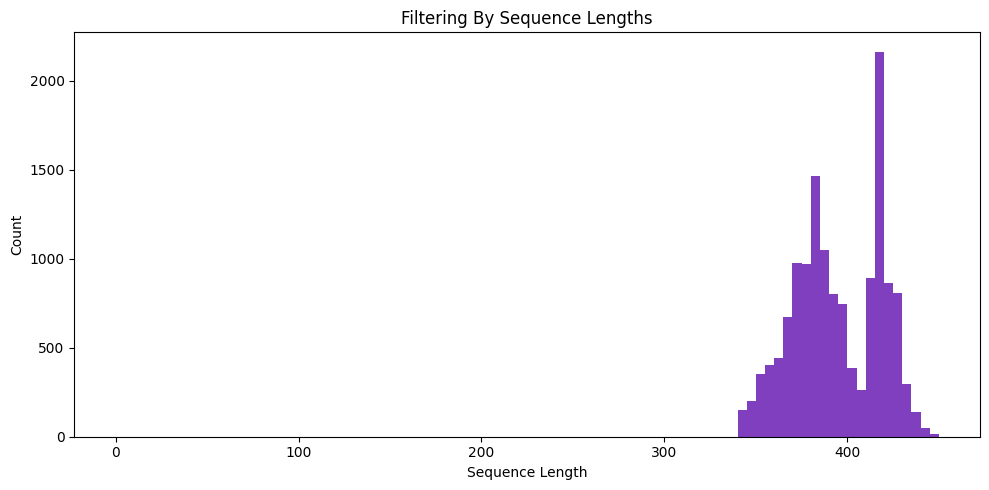

Filtering out sequences with strange sizes.
Out of 14094 sequences, 14094 remain.

Sequences saved in ../processed_sequences/hmm_align_no_cluster_23022023/seqs4.txt


In [7]:
if problem:
    raise Exception("Please resolve path issues before running this script, or set overwrite = True")

from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

def remove_gaps(seq_record):
    seq = seq_record.seq
    seq_without_gaps = Seq("".join(str(seq).split("-")))
    return SeqRecord(seq_without_gaps, id=seq_record.id, description=seq_record.description)

abnormal_sized_seqs = []
size_filtered_sequences = []
for seq in taxonomy_selected_sequences:
    ungapped = remove_gaps(seq)
    if(len(ungapped.seq) > 450 or len(ungapped.seq) < 300):
        abnormal_sized_seqs.append(seq)
    else:
        size_filtered_sequences.append(seq)
        
pre_filter = [len(remove_gaps(seq).seq) for seq in taxonomy_selected_sequences]
filtered = [len(remove_gaps(seq).seq) for seq in size_filtered_sequences]
  
bin_width = 5
bins = range(0, max(pre_filter + filtered) + bin_width, bin_width)

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(pre_filter, bins, color='red', alpha=0.5, label='Pre-Filter')
ax.hist(filtered, bins, color='blue', alpha=0.5, label='Filtered')
ax.set_title("Filtering By Sequence Lengths")
ax.set_xlabel("Sequence Length")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

print(f"Filtering out sequences with strange sizes.\nOut of {len(taxonomy_selected_sequences)} sequences, {len(size_filtered_sequences)} remain.")

size_filtered_sequences_filename = os.path.join(work_dir, "seqs4.txt")
SeqIO.write(size_filtered_sequences, size_filtered_sequences_filename, "fasta")

print(f"\nSequences saved in {size_filtered_sequences_filename}")

<h3 style="font-size:24px">4. Cluster sequences with Cluster.py</h3><br>

In [8]:
if problem:
    raise Exception("Please resolve path issues before running this script, or set overwrite = True")

cluster_script_filename = "../external_scripts/ClusterMSA.py"
cluster_dir = os.path.join(work_dir, "clusters/")
overwrite_cluster = False
cluster_min_size = 2
skip_cluster = True
clustered_sequences = []

print(f"Clustering sequences, and filtering out sequences with fewer than {cluster_min_size} sequences\n")
if(not skip_cluster):
    if os.path.exists(cluster_dir):
        print(f"Previous instance of cluster detected in {cluster_dir}\n")
        if overwrite_cluster:
            print(f"Overwriting all files in {cluster_dir}")
            !rm -rf {cluster_dir}
            !python $cluster_script_filename clst -i $size_filtered_sequences_filename -o $cluster_dir --gap_cutoff 1.0 --min_samples $cluster_min_size
        else:
            print("Preserving previously created files, skipping clustering step")
            size_filtered_sequences_filename = os.path.join(work_dir, "seqs4.txt")
            size_filtered_sequences = [seqrec for seqrec in SeqIO.parse(size_filtered_sequences_filename,"fasta")]
    else:
        print("Initiating clustering.")
        os.makedirs(cluster_dir)
        print(f"Clustering sequences in {cluster_dir}")
        !python $cluster_script_filename clst -i $size_filtered_sequences_filename -o $cluster_dir --gap_cutoff 1.0 --min_samples $cluster_min_size

    import re
    pattern = re.compile(r"clst_\d{3}\.a3m")
    for filename in os.listdir(cluster_dir):
        if pattern.match(filename):
            file_path = os.path.join(cluster_dir, filename)
            seqs = [seqrec for seqrec in SeqIO.parse(file_path,"fasta")]
            clustered_sequences += seqs
else:
    print("Skipping clustering step as requested, if you do not want this, please set skip_cluster to False!")
    clustered_sequences = copy.deepcopy(size_filtered_sequences)
    
print(f"\nFiltering out sequences without large clusters.\nOut of {len(size_filtered_sequences)} sequences, {len(clustered_sequences)} remain.")
clustered_sequences_filename = os.path.join(work_dir, "seqs5.txt")
SeqIO.write(clustered_sequences, clustered_sequences_filename, "fasta")

print(f"\nSequences saved in {clustered_sequences_filename}")

Clustering sequences, and filtering out sequences with fewer than 2 sequences

Skipping clustering step as requested, if you do not want this, please set skip_cluster to False!

Filtering out sequences without large clusters.
Out of 14094 sequences, 14094 remain.

Sequences saved in ../processed_sequences/hmm_align_no_cluster_23022023/seqs5.txt


<h3 style="font-size:24px">5. Remove highly similar sequences with CD-HIT</h3><br>

In [9]:
if problem:
    raise Exception("Please resolve path issues before running this script, or set overwrite = True")

identity_percentage = 0.95
ungapped_clustered_sequences_filename = os.path.join(work_dir, "seqs6.txt")
ungapped_low_similarity_sequences_filename = os.path.join(work_dir, "seqs7.txt")
low_similarity_sequences_filename = os.path.join(work_dir, "seqs8.txt")

ungapped_sequences = []
for seq in clustered_sequences:
    ungapped_sequences.append(remove_gaps(seq))

SeqIO.write(ungapped_sequences, ungapped_clustered_sequences_filename, "fasta")

print(f"Filtering out sequences with >{identity_percentage*100}% identity.\n")
!./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit -i $ungapped_clustered_sequences_filename -o $ungapped_low_similarity_sequences_filename -c $identity_percentage -n 5 -d 0 -T 8 -M 16000

ungapped_low_similarity_sequences = [seqrec for seqrec in SeqIO.parse(ungapped_low_similarity_sequences_filename,"fasta")]

low_similarity_sequences = []
for seq in ungapped_low_similarity_sequences:
    for seq2 in clustered_sequences:
        if(seq2.id == seq.id):
            low_similarity_sequences.append(seq2)
            break

if(len(low_similarity_sequences) != len(ungapped_low_similarity_sequences)):
    print(len(low_similarity_sequences), len(ungapped_low_similarity_sequences))
    raise Exception("Something has gone wrong, the filtered by id sequences don't map to the same sequences as clustered sequences.\n Have you run all previous code or overwritten files?")
    
print(f"\nFiltered out sequences with >{identity_percentage*100}% identity.")
print(f"Out of {len(clustered_sequences)} sequences, {len(low_similarity_sequences)} remain.")

SeqIO.write(low_similarity_sequences, low_similarity_sequences_filename, "fasta")
print(f"\nSequences saved in {low_similarity_sequences_filename}")

Filtering out sequences with >95.0% identity.

Program: CD-HIT, V4.8.1 (+OpenMP), Dec 13 2022, 11:04:39
Command: ./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit
         -i
         ../processed_sequences/hmm_align_no_cluster_23022023/seqs6.txt
         -o
         ../processed_sequences/hmm_align_no_cluster_23022023/seqs7.txt
         -c 0.95 -n 5 -d 0 -T 8 -M 16000

Started: Thu Feb 23 11:15:17 2023
                            Output                              
----------------------------------------------------------------
total seq: 14094
longest and shortest : 450 and 340
Total letters: 5554365
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 7M
Buffer          : 8 X 10M = 86M
Table           : 2 X 65M = 131M
Miscellaneous   : 0M
Total           : 224M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 1971917872

# comparing sequences from          0  to       1409
.--


<h3 style="font-size:24px">6. Check MSA and remove columns with no occurences</h3><br>

Removing columns that have no occurences anymore, as these are not valuable to us really


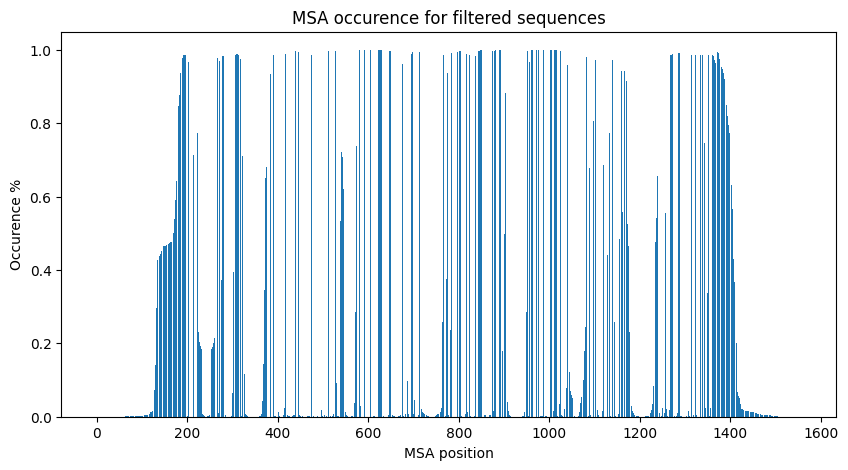

Out of 1557 MSA positions, only 1543 were actually ever being used


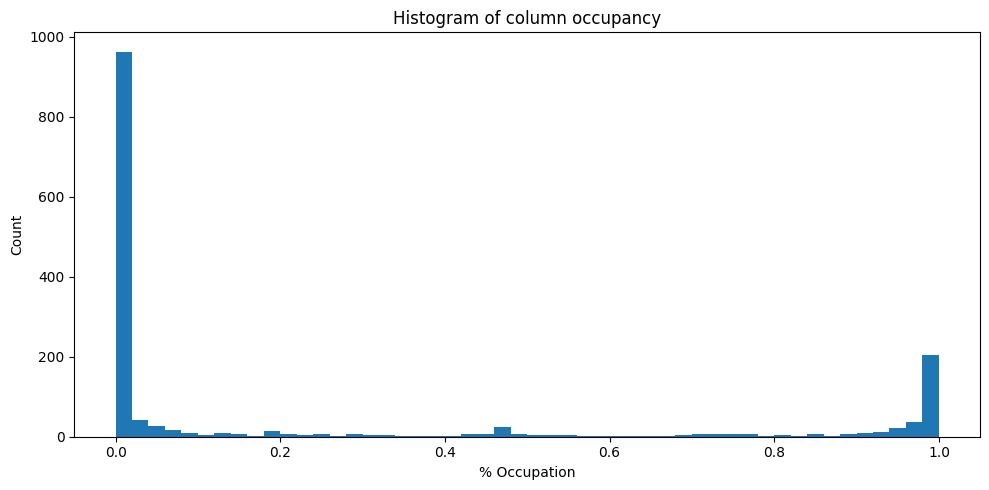

Reduced MSA size to 1543 residues.

Sequences saved in ../processed_sequences/hmm_align_no_cluster_23022023/seqs9.txt


In [10]:
import numpy as np

trimmed_sequences_filename = os.path.join(work_dir, "seqs9.txt")
print("Removing columns that have no occurences anymore, as these are not valuable to us really")

MSA_size = len(low_similarity_sequences[0].seq)
column_count = np.zeros(MSA_size)
for seq in low_similarity_sequences:
    column_count += np.array([1 if c != "-" else 0 for c in seq.seq])

column_count = column_count/len(low_similarity_sequences)
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(np.array(range(0,MSA_size)),column_count)
ax.set_xlabel("MSA position")
ax.set_ylabel("Occurence %")
ax.set_title("MSA occurence for filtered sequences")
plt.show()

trimmed_sequences = copy.deepcopy(low_similarity_sequences)

for seq in trimmed_sequences:
    filtered_seq = ''.join([seq.seq[i] for i in range(MSA_size) if column_count[i] != 0])
    seq.seq = Seq(filtered_seq)

print(f"Out of {MSA_size} MSA positions, only {len(trimmed_sequences[0].seq)} were actually ever being used")

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(column_count, bins = 50)
ax.set_title("Histogram of column occupancy")
ax.set_xlabel("% Occupation")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()
print(f"Reduced MSA size to {len(trimmed_sequences[0].seq)} residues.")
SeqIO.write(trimmed_sequences, trimmed_sequences_filename, "fasta")
print(f"\nSequences saved in {trimmed_sequences_filename}")


<h3 style="font-size:24px">Re-Perform Alignment because it doesn't cost that much</h3><br>


Clustal input sequences saved in ../processed_sequences/hmm_align_no_cluster_23022023/seqs10.txt
1177


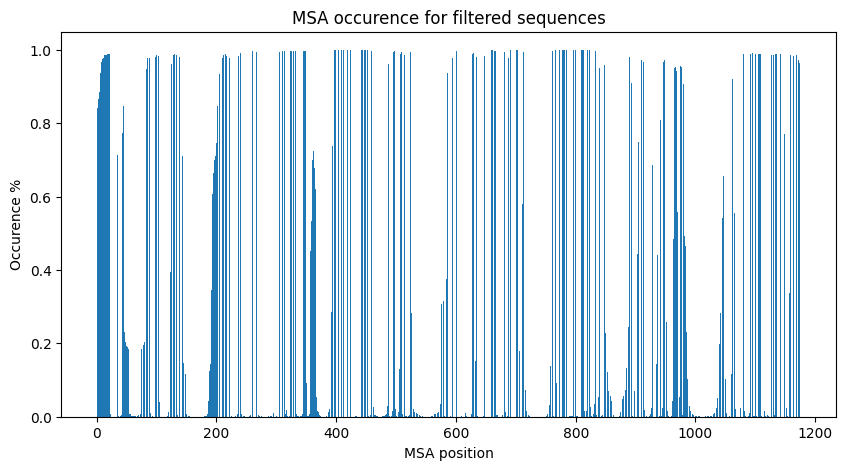

In [16]:
clustalo_hmm_input_filename = os.path.join(work_dir, "seqs10.txt")
hmm_sto_filename = os.path.join(work_dir, "seqs11.sto")
clustalo_hmm_output_filename = os.path.join(work_dir, "seqs11.txt")

hmm_model_filename = "../raw_sequences/MSA/YcaO_HMM.hmm"
clustalo_input_sequences = []
for sequence in trimmed_sequences:
    clustalo_input_sequences.append(remove_gaps(sequence))
    
SeqIO.write(clustalo_input_sequences, clustalo_hmm_input_filename, "fasta")
print(f"\nClustal input sequences saved in {clustalo_hmm_input_filename}")
    
#!clustalo --in $clustalo_hmm_input_filename --out $clustalo_hmm_output_filename --hmm-in $hmm_model_filename -v --force
!hmmalign --trim $hmm_model_filename  $clustalo_hmm_input_filename > $hmm_sto_filename 
alignment = AlignIO.read(hmm_sto_filename, "stockholm")
AlignIO.write(alignment, clustalo_hmm_output_filename, "fasta")

re_aligned_sequences = [seqrec for seqrec in SeqIO.parse(clustalo_hmm_output_filename,"fasta")]

print(len(re_aligned_sequences[0].seq))
#With the HMM built from just the MSA we get a new MSA of 1128 residues in length 1151 when using the default HMM from interpro
MSA_size = len(re_aligned_sequences[0].seq)
column_count = np.zeros(MSA_size)
for seq in re_aligned_sequences:
    column_count += np.array([1 if c != "-" else 0 for c in seq.seq])

column_count = column_count/len(re_aligned_sequences)
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(np.array(range(0,MSA_size)),column_count)
ax.set_xlabel("MSA position")
ax.set_ylabel("Occurence %")
ax.set_title("MSA occurence for filtered sequences")
plt.show()

In [ ]:
asr = True
redo = False

redo_text = "-redo"
asr_text = "-asr"
method = "WAG+F+I+G4"
import os

clustalo_hmm_output_filename = os.path.join(work_dir, "seqs11.txt")

# print(f"Creating tree, using method {method}, running on {len(re_aligned_sequences)} sequences.")
#Classic run:
!iqtree2 -s $clustalo_hmm_output_filename {(redo_text if redo else "")} -T 47 -m $method {(asr_text if asr else "")} -alrt 1000 -B 1000 --mlrate


# Modified run, get state file given topology:
# !iqtree2 -s $clustalo_hmm_output_filename -te ../processed_sequences/clustal_hmm_10_per_cluster_test_copy/seqs11.txt.treefile -T 47 -m $method {(asr_text if asr else "")}




******************************************************
CHECKPOINT: Resuming analysis from ../processed_sequences/hmm_align_no_cluster_23022023/seqs11.txt.ckp.gz

IQ-TREE multicore version 2.2.0 COVID-edition for Linux 64-bit built Jun  1 2022
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    dc4b1604e884 (AVX2, FMA3, 251 GB RAM)
Command: iqtree2 -s ../processed_sequences/hmm_align_no_cluster_23022023/seqs11.txt -T 47 -m WAG+F+I+G4 -asr -alrt 1000 -B 1000 --mlrate
Seed:    588245 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Sat Feb 25 15:50:06 2023
Kernel:  AVX+FMA - 47 threads (48 CPU cores detected)

Reading alignment file ../processed_sequences/hmm_align_no_cluster_23022023/seqs11.txt ... Fasta format detected
Reading fasta file: done in 0.189161 secs using 91.35% CPU
Alignment most likely contains protein sequences
Constructing alignment: done in 0.0784132 s

1035  A0A1B6YPA2   72.39%    passed      8.56%
1036  A0A1B6Z012   71.88%    failed      2.31%
1037  A0A1B7JDC8   71.71%    passed     31.79%
1038  A0A1B7K0N9   71.71%    passed      6.69%
1039  A0A1B7UWK9   71.96%    passed     61.63%
1040  A0A1B8H520   71.71%    passed     17.38%
1041  A0A1B8R0F6   71.71%    failed      0.25%
1042  A0A1B8R6C2   73.41%    failed      2.87%
1043  A0A1B8R8D6   72.22%    passed     29.66%
1044  A0A1B8RH12   72.81%    failed      2.36%
1045  A0A1B8VC79   71.45%    failed      3.64%
1046  A0A1B8WK32   71.20%    passed     22.68%
1047  A0A1B9AJN1   71.62%    passed     37.17%
1048  A0A1B9ERC3   70.09%    failed      0.13%
1049  A0A1B9EVQ9   71.54%    failed      0.06%
1050  A0A1B9F5D0   73.92%    passed     25.10%
1051  A0A1B9JH58   71.79%    failed      0.86%
1052  A0A1B9JV03   71.71%    failed      1.74%
1053  A0A1B9JZI6   71.71%    failed      0.00%
1054  A0A1B9K953   71.71%    failed      0.46%
1055  A0A1B9KKY9   71.71%    failed      2.99%
1056  A0A1B9K

5107  A0A6G8RVN1   71.62%    failed      2.34%
5108  A0A6G8S2M7   71.45%    failed      3.33%
5109  A0A6G9IE13   71.71%    failed      0.06%
5110  A0A6G9QJ16   71.79%    failed      0.02%
5111  A0A6G9SQA3   71.62%    failed      0.68%
5112  A0A6G9YIN9   73.83%    passed      7.66%
5113  A0A6G9YQJ4   71.03%    passed     25.33%
5114  A0A6G9Z7R6   70.69%    failed      0.30%
5115  A0A6H0ARJ7   70.60%    failed      0.00%
5116  A0A6H0ARR1   71.62%    failed      0.00%
5117  A0A6H0ATT7   72.30%    failed      0.00%
5118  A0A6H0CR24   71.79%    failed      0.01%
5119  A0A6H0CT06   73.41%    failed      0.00%
5120  A0A6H0K455   71.71%    passed     32.26%
5121  A0A6H0T3M2   71.71%    failed      0.93%
5122  A0A6H1NFM3   74.09%    passed      7.24%
5123  A0A6H1RAF1   70.52%    passed     98.55%
5124  A0A6H1WTT8   73.92%    passed      6.26%
5125  A0A6H2D327   73.83%    passed      8.47%
5126  A0A6H2EJX6   72.90%    passed      6.60%
5127  A0A6H2GSQ6   72.05%    passed     43.62%
5128  A0A6H3F


CHECKPOINT: Initial tree restored
Generating 1000 samples for ultrafast bootstrap (seed: 588245)...
CHECKPOINT: 1000 UFBoot trees and 7 UFBootSplits restored

NOTE: 5151 MB RAM (5 GB) is required!
CHECKPOINT: Model parameters restored, LogL: -2500862.950
Wrote distance file to... 
--------------------------------------------------------------------
|             INITIALIZING CANDIDATE TREE SET                      |
--------------------------------------------------------------------
CHECKPOINT: Candidate tree set restored, best LogL: -2500862.950
Finish initializing candidate tree set (20)
Current best tree score: -2500862.950 / CPU time: 0.000
Number of iterations: 396
--------------------------------------------------------------------
|               OPTIMIZING CANDIDATE TREE SET                      |
--------------------------------------------------------------------
Optimizing NNI: done in 249.591 secs using 4130% CPU
Optimizing NNI: done in 231.317 secs using 4158% CPU
Optimi

In [ ]:
!iqtree2 -s $clustalo_hmm_output_filename -T 47 -t {clustalo_hmm_output_filename+".treefile"} -n 0 --mlrate -m $method



In [8]:
!iqtree2 -h


IQ-TREE multicore version 2.2.0 COVID-edition for Linux 64-bit built Jun  1 2022
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Usage: iqtree [-s ALIGNMENT] [-p PARTITION] [-m MODEL] [-t TREE] ...

GENERAL OPTIONS:
  -h, --help           Print (more) help usages
  -s FILE[,...,FILE]   PHYLIP/FASTA/NEXUS/CLUSTAL/MSF alignment file(s)
  -s DIR               Directory of alignment files
  --seqtype STRING     BIN, DNA, AA, NT2AA, CODON, MORPH (default: auto-detect)
  -t FILE|PARS|RAND    Starting tree (default: 99 parsimony and BIONJ)
  -o TAX[,...,TAX]     Outgroup taxon (list) for writing .treefile
  --prefix STRING      Prefix for all output files (default: aln/partition)
  --seed NUM           Random seed number, normally used for debugging purpose
  --safe               Safe likelihood kernel to avoid numerical underflow
  --mem NUM[G|M|%]     Maximal RAM usage in GB | MB | %
  --runs NU